### Что изменено?

- **[Wind of Change](https://www.youtube.com/watch?v=n4RjJKxsamQ)**
- **[Humanity](https://www.youtube.com/watch?v=0755SXCTCN0)**
- **[Send Me an Angel](https://www.youtube.com/watch?v=1UUYjd2rjsE)**

При финансовой поддержке
- **[newYORK.MOV](https://www.youtube.com/watch?v=isgLNVugJLw)**

<!-- # TODO: подрочить параметры Trainer-а, чтобы попробовать добиться f-score хотя бы 0.7 -->

<!-- # TODO: добавить аугментацию данных (оригинальных данных слишком мало, на 10-й эпохе цже наступает оверыит) -->

In [ ]:
# !!!!!! DATASETS 3.0.0 ТЕПЕРЬ СТАВИТ NUMPY 2 И ЭТИМ ЛОМАЕТ ДРУГИЕ ЗАВИСИМОСТИ !!!!!!

# ЧТОБЫ ПАЧЕНИТЬ:
# 1. sudo apt remove python* -y
# 2. sudo rm -r ~/.local/lib/python3.10/
# 3. sudo apt install python3 pip -y
# 4. pip install "spacy==3.7" "numpy<2.0" scipy
# 5. pip install "datasets<3" "transformers[torch]<4.46"
# 6. pip install "evaluate<=0.4.3"
# 7. pip install ipykernel scikit-learn matplotlib torch seqeval nltk jupyter tensorboard

# (господи, как же я люблю полурабочие зависимости питона, mmmm oaooaa...)

In [2]:
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline
from transformers import EarlyStoppingCallback
import evaluate
# from nltk.tokenize.treebank import TreebankWordDetokenizer # НИНУЖНО

from spacy import displacy # "Для красивых визуализаций"
from tqdm.notebook import tqdm # Не менее красивое отображение прогресс-баров
import matplotlib.colors as mcolors # Красиво раскрасим наши именованные сущности

import os
import random
from typing import Dict, List, Tuple, Union # Эмуляция статической типизации

import numpy as np
import torch

# from seqeval.scheme import IOB2 # НИНУЖНО
from seqeval.metrics import classification_report

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data]   Package wordnet is already up-to-date!


Вытряхиваем прошлые данные из видеопамяти, если таковые остались

In [3]:
UNLOAD_MODEL = True

if UNLOAD_MODEL:
    try:
        del trainer
        del model
        del tokenizer
    except:
        pass

    torch.cuda.empty_cache()

    from gc import collect
    collect()

Фиксируем все рандом сиды, которые только можем

In [4]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# 1. Загрузим данные
Хороший датасет для **NER** (Named Entity Recognition — [вычленение определённых сущностей из текста](https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus)) по текстам на тему астрофизики.

Этой задаче в 2022 году была посвящена статья https://aclanthology.org/2022.wiesp-1.1.pdf и даже целый воркшоп https://ui.adsabs.harvard.edu/WIESP/
 
Ссылка на данные https://huggingface.co/datasets/adsabs/WIESP2022-NER

In [5]:
DATASET_NAME = 'adsabs/WIESP2022-NER'
dataset_train = load_dataset(DATASET_NAME, split='train')

### Посмотрим на содержимое датасета поближе

In [6]:
for k in sorted(dataset_train[5].keys()):
    print(k)

bibcode
label_studio_id
ner_ids
ner_tags
section
tokens
unique_id


In [7]:
for k in range(len(dataset_train[5]['tokens'])):
    # Не сущность а фигня просто
    if dataset_train[5]["ner_tags"][k] == 'O':
        print('\033[35m', end='')

    # Начало сущности
    elif dataset_train[5]["ner_tags"][k].startswith('B-'):
        print('\033[32m', end='')

    # Продолжение сущности (концов в датасете нет)
    elif dataset_train[5]["ner_tags"][k].startswith('I-'):
        print('\033[34m', end='')

    print(f'{dataset_train[5]["tokens"][k]} -- {dataset_train[5]["ner_tags"][k]} ({dataset_train[5]["ner_ids"][k]})')

    print('\033[0m', end='')

I -- O (62)
thank -- O (62)
Duncan -- B-Person (22)
Galloway, -- I-Person (53)
Zac -- B-Person (22)
Johnston, -- I-Person (53)
and -- O (62)
Hendrik -- B-Person (22)
Schatz -- I-Person (53)
for -- O (62)
useful -- O (62)
discussions, -- O (62)
and -- O (62)
acknowledge -- O (62)
the -- O (62)
instructive -- O (62)
tutorials -- O (62)
from -- O (62)
Ed -- B-Person (22)
Brown, -- I-Person (53)
Andrew -- B-Person (22)
Cumming, -- I-Person (53)
and -- O (62)
Rob -- B-Person (22)
Farmer -- I-Person (53)
located -- O (62)
on -- O (62)
the -- O (62)
MESA -- B-Software (24)
Marketplace -- I-Software (55)
( -- O (62)
http://cococubed.asu.edu/mesa_market/ -- B-URL (29)
) -- O (62)
that -- O (62)
helped -- O (62)
at -- O (62)
the -- O (62)
beginning -- O (62)
stages -- O (62)
of -- O (62)
this -- O (62)
work. -- O (62)
Relevant -- O (62)
MESA -- B-Software (24)
inputs -- O (62)
for -- O (62)
this -- O (62)
work -- O (62)
are -- O (62)
available -- O (62)
on -- O (62)
the -- O (62)
MESA -- B-Softw

In [8]:
for k in range(len(dataset_train[5]['tokens'])):
    if dataset_train[5]["ner_tags"][k] != 'O':
        print(f'{dataset_train[5]["tokens"][k]} -- {dataset_train[5]["ner_tags"][k]} ({dataset_train[5]["ner_ids"][k]})')

Duncan -- B-Person (22)
Galloway, -- I-Person (53)
Zac -- B-Person (22)
Johnston, -- I-Person (53)
Hendrik -- B-Person (22)
Schatz -- I-Person (53)
Ed -- B-Person (22)
Brown, -- I-Person (53)
Andrew -- B-Person (22)
Cumming, -- I-Person (53)
Rob -- B-Person (22)
Farmer -- I-Person (53)
MESA -- B-Software (24)
Marketplace -- I-Software (55)
http://cococubed.asu.edu/mesa_market/ -- B-URL (29)
MESA -- B-Software (24)
MESA -- B-Software (24)
Marketplace. -- I-Software (55)
U.S. -- B-Location (16)
Department -- B-Organization (21)
of -- I-Organization (52)
Energy -- I-Organization (52)
DE-FG02-88ER40387. -- B-Grant (13)
National -- B-Organization (21)
Science -- I-Organization (52)
Foundation -- I-Organization (52)
PHY-1430152 -- B-Grant (13)
(Joint -- B-Organization (21)
Institute -- I-Organization (52)
for -- I-Organization (52)
Nuclear -- I-Organization (52)
Astrophysics–Center -- I-Organization (52)
for -- I-Organization (52)
the -- I-Organization (52)
Evolution -- I-Organization (52)
o

### Посмотрим на все теги сущностей (и их кол-во)

In [9]:
labels = dict()
for it in dataset_train['ner_tags']:
    for entity in list(set(it)):
        if labels.get(entity):
            labels[entity] += it.count(entity)
        else:
            labels[entity] = it.count(entity)

for w in sorted(labels, key=labels.get, reverse=True):
    print(f'{w} -- {labels[w]}')

print(f'\nВсего ТЕГОВ сущностей: {len(labels)}.')

O -- 472307
I-Citation -- 18402
I-Organization -- 14211
I-Formula -- 8433
B-Organization -- 7448
B-Citation -- 6360
I-Grant -- 4080
B-Person -- 3916
B-Grant -- 3478
B-Wavelength -- 3384
B-CelestialObject -- 2940
I-Person -- 2206
B-Formula -- 2088
B-Model -- 1800
I-CelestialObject -- 1691
I-Wavelength -- 1583
B-Telescope -- 1573
B-Location -- 1404
I-Model -- 1244
I-Observatory -- 1035
B-Software -- 1017
I-Fellowship -- 1015
B-Survey -- 885
B-Observatory -- 873
I-ComputingFacility -- 809
B-Instrument -- 714
I-Telescope -- 607
I-Collaboration -- 598
I-Survey -- 573
I-Software -- 472
I-Location -- 467
I-Archive -- 466
B-Fellowship -- 411
B-ComputingFacility -- 399
I-Dataset -- 368
B-Dataset -- 328
B-Collaboration -- 306
B-URL -- 294
B-CelestialObjectRegion -- 265
I-Database -- 259
B-Database -- 256
I-CelestialRegion -- 240
I-CelestialObjectRegion -- 223
B-Archive -- 192
I-Event -- 176
B-CelestialRegion -- 158
I-Instrument -- 140
B-ObservationalTechniques -- 124
B-Identifier -- 112
B-Missio

### Посмотрим на все классы и их кол-во

In [10]:
entity_classes = (#sorted(
    list(set(
        map(
            lambda it2: it2[2:],
            filter(
                lambda it1: it1 != 'O',
                list(labels)
            )
        )
    ))
)

for it in entity_classes:
    print(it)

print(f'\nВсего КЛАССОВ сущностей: {len(entity_classes)}.')

Archive
Tag
TextGarbage
Event
CelestialObject
Survey
Mission
Instrument
ObservationalTechniques
Dataset
Database
Formula
URL
CelestialObjectRegion
Location
Observatory
Software
Grant
Collaboration
Citation
Model
Proposal
Person
Telescope
Fellowship
ComputingFacility
EntityOfFutureInterest
Identifier
Organization
CelestialRegion
Wavelength

Всего КЛАССОВ сущностей: 31.


Почему классов в два раза меньше тегов? — Потому что теги имеют разметку формата "**BILOU**" — [начало сущности, продолжение сущности, конец сущности, не-сущность, одиночный токен-сущность соответстчвенно](https://stackoverflow.com/questions/17116446/what-do-the-bilou-tags-mean-in-named-entity-recognition) — а хотя нет, обманул, формат будет "**BIO**", потому что тегов типа L и U в датасете нет — и при этом каждый тег, очевидно, принадлежит к какому-то из классов сущеностей.

### Визуализируем текст с разметкой

Для этого сперва загрузим токенизатор:

In [11]:
MODEL_NAME = 'FacebookAI/xlm-roberta-base' # XLM-RoBERTa -- бертоподобный языконезависимый трансформер-энкодер
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [12]:
entity_colors = [
    mcolors.rgb2hex((0.6 + random.random() / 4, 0.6 + random.random() / 4, 0.6 + random.random() / 4))
    for _ in range(len(entity_classes))
]

assert len(entity_classes) == len(entity_colors)

In [13]:
def bio_to_spans(bio: List[str]) -> List[Dict[str, Union[int, str]]]:
    """
    Функция нужна для красивого изображения текста с именованными сущностями
    с использованием displacy https://spacy.io/usage/visualizers в стиле "span".
    """
    ne_tag = ''
    start_pos = -1
    bounds = []

    for idx, val in enumerate(bio):
        if val.upper() == 'O':
            if start_pos >= 0:
                bounds.append({
                    'start_token': start_pos,
                    'end_token': idx,
                    'label': ne_tag
                })
            start_pos = -1
            ne_tag = ''
        elif val.upper().startswith('B-'):
            if start_pos >= 0:
                bounds.append({
                    'start_token': start_pos,
                    'end_token': idx,
                    'label': ne_tag
                })
            start_pos = idx
            ne_tag = val[2:]
    if start_pos >= 0:
        bounds.append({
            'start_token': start_pos,
            'end_token': len(bio),
            'label': ne_tag
        })

    return bounds

In [14]:
def bio_to_ents(tokens: List[str], bio: List[str]) -> Tuple[str, List[Dict[str, Union[int, str]]]]:
    """
    Функция нужна для ещё более красивого изображения текста с именованными сущностями
    с использованием displacy https://spacy.io/usage/visualizers в стиле "ent".
    """
    if len(tokens) != len(bio):
        err_msg = f'Расхождение длины списка токенов и списка сущностей: {len(tokens)} != {len(bio)}!'
        raise RuntimeError(err_msg)

    # https://github.com/huggingface/transformers/issues/14502
    full_text = tokenizer.convert_tokens_to_string(
        list(map(lambda t: t+' ', tokens))
    )
    # print(full_text, tokens)
    token_bounds = []
    previous_pos = 0

    for cur in tokens:
        found_idx = full_text[previous_pos:].find(cur)
        if found_idx < 0:
            err_msg = f'Токен "{cur}" не найден в тексте "{full_text}", хотя заявлено, что он существует!'
            raise RuntimeError(err_msg)
        token_start = found_idx + previous_pos
        token_end = token_start + len(cur)
        token_bounds.append((token_start, token_end))
        previous_pos = token_end

    entity_spans = bio_to_spans(bio)
    entity_bounds = []

    for cur in entity_spans:
        entity_class = cur['label']
        entity_start = token_bounds[cur['start_token']][0]
        entity_end = token_bounds[cur['end_token'] - 1][1]
        entity_bounds.append({
            'start': entity_start,
            'end': entity_end,
            'label': entity_class
        })

    del token_bounds, entity_spans
    return full_text, entity_bounds

Визуализации одна красивше другой

In [15]:
rendered_by_spans = displacy.render(
    style='span',
    docs={
        'text': tokenizer.decode(
            tokenizer.convert_tokens_to_ids(dataset_train[5]['tokens'])
        ),
        'spans': bio_to_spans(dataset_train[5]['ner_tags']),
        'tokens': dataset_train[5]['tokens'],
    },
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True,
)

In [16]:
rendered_by_ents = displacy.render(
    style='ent',
    docs=dict(zip(
        ('text', 'ents'),
        bio_to_ents(
            dataset_train[5]['tokens'],
            dataset_train[5]['ner_tags']
        )
    )),
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)

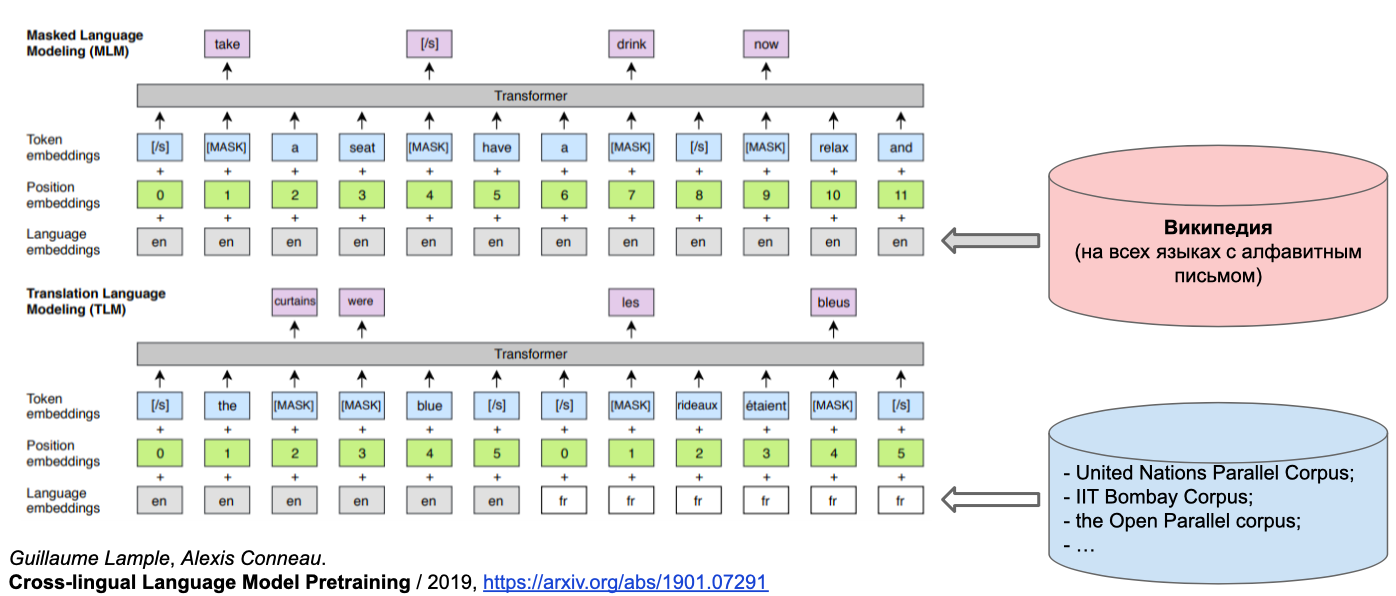

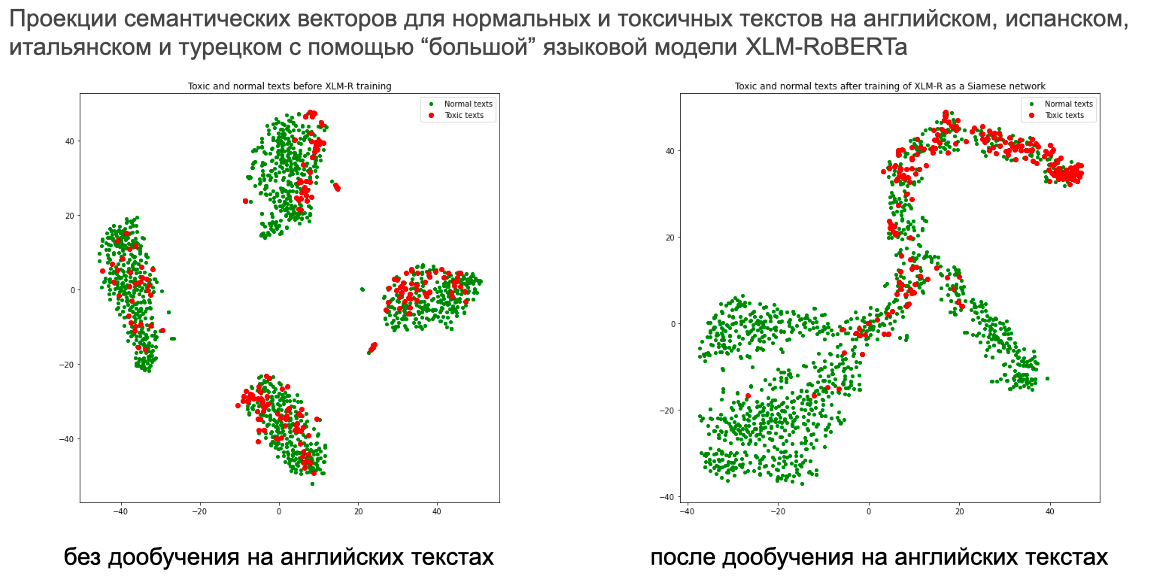

In [17]:
example = dataset_train[5]
example_tokenized_input = tokenizer(example['tokens'], is_split_into_words=True)
example_tokens = tokenizer.convert_ids_to_tokens(example_tokenized_input['input_ids'])
print(example_tokens)

['<s>', '▁I', '▁thank', '▁Dun', 'can', '▁Gall', 'o', 'way', ',', '▁Za', 'c', '▁John', 'ston', ',', '▁and', '▁Hendrik', '▁Scha', 'tz', '▁for', '▁useful', '▁discussion', 's', ',', '▁and', '▁acknowledge', '▁the', '▁in', 'struct', 'ive', '▁tutorial', 's', '▁from', '▁Ed', '▁Brown', ',', '▁Andrew', '▁Cum', 'ming', ',', '▁and', '▁Rob', '▁Farm', 'er', '▁located', '▁on', '▁the', '▁M', 'ESA', '▁Market', 'place', '▁(', '▁http', '://', 'co', 'co', 'cu', 'bed', '.', 'asu', '.', 'edu', '/', 'mesa', '_', 'market', '/', '▁)', '▁that', '▁helped', '▁at', '▁the', '▁beginning', '▁stage', 's', '▁of', '▁this', '▁work', '.', '▁Re', 'le', 'vant', '▁M', 'ESA', '▁input', 's', '▁for', '▁this', '▁work', '▁are', '▁available', '▁on', '▁the', '▁M', 'ESA', '▁Market', 'place', '.', '▁This', '▁work', '▁was', '▁support', 'ed', '▁in', '▁part', '▁by', '▁the', '▁U', '.', 'S', '.', '▁Department', '▁of', '▁Energy', '▁under', '▁grant', '▁No', '.', '▁DE', '-', 'FG', '02', '-', '88', 'ER', '40', '387', '.', '▁This', '▁material'

# 2. Аугментируем датасет

Моя идея заключается в следующем:
1. Для замены O-сущностей использовать nlpaug для отдельно взятого датасета синонимов (датасет на английском, поэтому пусть будет WordNet, в случае с русским языком подошёл бы RuWordNet)
2. Для замены действительных сущностей выделить все существующие теги сущностей во всём датасете по классам сущностей (то есть выделить все теги, сгруппировать и конкатенировать) и случайно заменять их на аналогичные

In [ ]:
entity_dict = {}


for it in dataset_train:
    current_entity = []
    current_tag = None

    for token, tag in zip(it['tokens'], it['ner_tags']):
        if tag.startswith('B-'): # Начало новой сущности
            # Добавляем предыдущую сущность в список, если она есть
            if current_entity:
                if current_tag not in entity_dict:
                    entity_dict[current_tag] = []
                entity_dict[current_tag].append(' '.join(current_entity))

            current_entity = [token]
            current_tag = tag[2:]

        elif tag.startswith('I-') and current_tag: # Продолжение сущности
            # Прибавляем эту часть к началу этой же сущности
            current_entity.append(token)

        else: # Nonent-сущность, пропускаем её
            # Добавляем предыдущую сущность в список, если она есть
            if current_entity:
                if current_tag not in entity_dict:
                    entity_dict[current_tag] = []
                entity_dict[current_tag].append(' '.join(current_entity))

            current_entity = []
            current_tag = None

    if current_entity: # Добавляем последнюю сущность
        if current_tag not in entity_dict:
            entity_dict[current_tag] = []
        entity_dict[current_tag].append(" ".join(current_entity))

In [ ]:
random.seed(RANDOM_SEED) # На всякий случай фиксируем сид ещё раз

dataset_train_synonymized = []


for it in dataset_train:
    # Сперва добавим синонимы для тегов типа "O", т.е. для nonent-сущностей
    synonyms = []

    for idx, token in enumerate(it['tokens']):
        if it['ner_tags'][idx] !='O': # Другие виды токенов мы обработаем чуточку позже
            synonyms.append(None)

        elif len(token) <= 4: # Нет смысла искать синонимы для всяких там местоимений
            synonyms.append(token)

        else:
            synsets = wordnet.synsets(token.lower()) # Словарь работает только с lowercase-ом

            if synsets: # Перебираем все возможные альтернативы
                found_synonym = None
                for synset in synsets:
                    for lemma in synset.lemmas():
                        if lemma.name() != token:
                            found_synonym = (lemma.name()).replace('_', ' ')
                            synonyms.append(found_synonym)
                            break
                    if found_synonym:
                        break
                if not found_synonym:
                    synonyms.append(token)

            else: # Увы, ни одной альтеранитивы не найдено
                synonyms.append(token)

    # Теперь заменим все остальные виды сущеностей на случайные сущности этого же класса
    new_tokens = []
    new_tags = []    

    for (token, tag) in zip(synonyms, it['ner_tags']):
        if tag.startswith('B-'): # Начало сущности
            entity_class = tag[2:] # Класс сущности

            if entity_class in entity_dict: # Выбираем случайную сущность из словаря
                new_entity_tokens = (random.choice(entity_dict[entity_class])).split()

                # Сохраняем изначальную длину новой сущности
                new_tokens.extend(new_entity_tokens)
                new_tags.extend(
                    [f'B-{entity_class}'] + [f'I-{entity_class}'] * (len(new_entity_tokens)-1)
                )

            else: # Если сущностей нет, оставляем оригинал
                new_tokens.append(token)
                new_tags.append(tag)

        elif tag.startswith('I-'): # Продолжение сущности
            continue # Пропускаем, т.к. мы уже выделили эту же сущность ранее

        else:
            # Для токенов без сущностей оставляем оригинал
            new_tokens.append(token)
            new_tags.append(tag)


    dataset_train_synonymized.append({'tokens': new_tokens, 'ner_tags': new_tags})

In [20]:
rendered_aug_before = displacy.render(
    style='ent',
    docs=dict(zip(
        ('text', 'ents'),
        bio_to_ents(
            dataset_train[13]['tokens'],
            dataset_train[13]['ner_tags']
        )
    )),
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)


rendered_aug_after = displacy.render(
    style='ent',
    docs=dict(zip(
        ('text', 'ents'),
        bio_to_ents(
            dataset_train_synonymized[13]['tokens'],
            dataset_train_synonymized[13]['ner_tags']
        )
    )),
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)

In [ ]:
dataset_train_augemnted_list = []

for orig, aug in zip(dataset_train, dataset_train_synonymized):
    dataset_train_augemnted_list.append({'tokens': orig['tokens'], 'ner_tags': orig['ner_tags']})
    dataset_train_augemnted_list.append({'tokens': aug['tokens'], 'ner_tags': aug['ner_tags']})
# random.shuffle(dataset_train_augemnted_list) # Перемешаем новый датасет, потому что почему бы и нет

# Преобразуем в объект Dataset
dataset_train_augmented = Dataset.from_dict({
    'tokens': [example['tokens'] for example in dataset_train_augemnted_list],
    'ner_tags': [example['ner_tags'] for example in dataset_train_augemnted_list]
})

print(dataset_train_augmented)

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 3506
})


Здесь и далее, вместо dataset_train, мы будем использовать уже dataset_train_augmented!

# 3. Токенизируем текст

Очень важно, чтобы порядок классов сущностей совпадал с датасетом (а в датасете они посортированы именно так, как ниже):

In [22]:
label_list = ['O'] + sorted(list(labels.keys() - {'O'}))
print(label_list)

['O', 'B-Archive', 'B-CelestialObject', 'B-CelestialObjectRegion', 'B-CelestialRegion', 'B-Citation', 'B-Collaboration', 'B-ComputingFacility', 'B-Database', 'B-Dataset', 'B-EntityOfFutureInterest', 'B-Event', 'B-Fellowship', 'B-Formula', 'B-Grant', 'B-Identifier', 'B-Instrument', 'B-Location', 'B-Mission', 'B-Model', 'B-ObservationalTechniques', 'B-Observatory', 'B-Organization', 'B-Person', 'B-Proposal', 'B-Software', 'B-Survey', 'B-Tag', 'B-Telescope', 'B-TextGarbage', 'B-URL', 'B-Wavelength', 'I-Archive', 'I-CelestialObject', 'I-CelestialObjectRegion', 'I-CelestialRegion', 'I-Citation', 'I-Collaboration', 'I-ComputingFacility', 'I-Database', 'I-Dataset', 'I-EntityOfFutureInterest', 'I-Event', 'I-Fellowship', 'I-Formula', 'I-Grant', 'I-Identifier', 'I-Instrument', 'I-Location', 'I-Mission', 'I-Model', 'I-ObservationalTechniques', 'I-Observatory', 'I-Organization', 'I-Person', 'I-Proposal', 'I-Software', 'I-Survey', 'I-Tag', 'I-Telescope', 'I-TextGarbage', 'I-URL', 'I-Wavelength']


In [23]:
def tokenize_and_align_labels(examples: List[List[str]]):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)
    label_list_of_id_lists = []

    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i) # Мапает токены соответствующим им словам
        previous_word_idx = None
        label_ids = []

        # У специальных токенов ставим инедкс -100, чтобы
        # в дальнейшем их было удобно отсеивать от остальных
        for word_idx in word_ids:
            if word_idx is None:
                # pass
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # Помечаем только первый токен слова
                label_ids.append(label_list.index(label[word_idx]))
            else:
                # pass
                label_ids.append(-100)

            previous_word_idx = word_idx
        label_list_of_id_lists.append(label_ids)

    tokenized_inputs['labels'] = label_list_of_id_lists
    return tokenized_inputs

In [24]:
tokenized_dataset_train = dataset_train_augmented.map(tokenize_and_align_labels, batched=True)

for k in sorted(tokenized_dataset_train[5].keys()):
    print(f'{k}\t{tokenized_dataset_train[5][k]}')

Map:   0%|          | 0/3506 [00:00<?, ? examples/s]

attention_mask	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
input_ids	[0, 230466, 581, 6, 70035, 8337, 45458, 142, 142, 191, 5, 107832, 13, 100, 456, 10015, 136, 199015, 450, 90254, 33, 2446, 29053, 32032, 5, 36947, 27391, 425, 4, 1747, 51606, 45023, 538, 36456, 19574, 50930, 674, 1295, 70, 6, 54761, 136, 70, 43975, 111, 46473, 183037, 70, 8273, 123342, 29089, 69253, 53, 15, 294, 8218, 16, 9593, 17336, 5, 237, 5299, 237, 19574, 50930, 674, 1295, 10, 15, 74965, 82350, 70318, 438, 5, 36213, 5, 284, 91685, 9323, 5, 2]
labels	[-100, 0, 0, 0, -100, 0, -100, 0, 0, -100, -100, 0, -100, 0, 0, -100, 0, 0, 0, 0, -100, 0, 0, -100, -100, 23, 54, -100, -100, 0, -100, -100, -100, 0, 0, -100, -100, 0, 0, 22, -100, 0, 0, 22, 53, 53, 0, 0, 12, -100, -100, 43, -100, 43, -100, -100, -100, 43, -100, -100, 0, 0

# 4. Загрузим метрику

In [25]:
seqeval = evaluate.load('seqeval')

In [26]:
def compute_metrics(p):
    preds_p, labels_p = p
    preds_max_p = np.argmax(preds_p, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds_max_p, labels_p)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(preds_max_p, labels_p)
    ]

    results = seqeval.compute(
        predictions=true_preds,
        references=true_labels
    )

    return {
        'precision': results['overall_precision'],
        'recall': results['overall_recall'],
        'accuracy': results['overall_accuracy'],
        'f1': results['overall_f1']
    }

"Соединяем" id тегов сущности и их названия

In [27]:
id2label = dict(enumerate(label_list))
label2id = dict((val, idx) for idx, val in enumerate(label_list))

print('id2label:', id2label)
print('')
print('label2id:', label2id)

id2label: {0: 'O', 1: 'B-Archive', 2: 'B-CelestialObject', 3: 'B-CelestialObjectRegion', 4: 'B-CelestialRegion', 5: 'B-Citation', 6: 'B-Collaboration', 7: 'B-ComputingFacility', 8: 'B-Database', 9: 'B-Dataset', 10: 'B-EntityOfFutureInterest', 11: 'B-Event', 12: 'B-Fellowship', 13: 'B-Formula', 14: 'B-Grant', 15: 'B-Identifier', 16: 'B-Instrument', 17: 'B-Location', 18: 'B-Mission', 19: 'B-Model', 20: 'B-ObservationalTechniques', 21: 'B-Observatory', 22: 'B-Organization', 23: 'B-Person', 24: 'B-Proposal', 25: 'B-Software', 26: 'B-Survey', 27: 'B-Tag', 28: 'B-Telescope', 29: 'B-TextGarbage', 30: 'B-URL', 31: 'B-Wavelength', 32: 'I-Archive', 33: 'I-CelestialObject', 34: 'I-CelestialObjectRegion', 35: 'I-CelestialRegion', 36: 'I-Citation', 37: 'I-Collaboration', 38: 'I-ComputingFacility', 39: 'I-Database', 40: 'I-Dataset', 41: 'I-EntityOfFutureInterest', 42: 'I-Event', 43: 'I-Fellowship', 44: 'I-Formula', 45: 'I-Grant', 46: 'I-Identifier', 47: 'I-Instrument', 48: 'I-Location', 49: 'I-Missi

# 5. Загрузим модель

...а также датасет для валидации и [коллатор](https://huggingface.co/docs/transformers/main_classes/data_collator)

In [28]:
dataset_val = load_dataset(DATASET_NAME, split='validation')

tokenized_dataset_val = dataset_val.map(tokenize_and_align_labels, batched=True)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [29]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels.keys()),
    id2label=id2label,
    label2id=label2id
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[HF-овский тренировщик](https://huggingface.co/docs/transformers/main_classes/trainer) на базе [AdamW](https://habr.com/ru/articles/813221/):

In [30]:
MODEL_NAME_ON_DISK = os.path.abspath('astro_ner')

training_args = TrainingArguments(
    learning_rate=3e-5,

    num_train_epochs=20, # Трейн одной эпохи занимает 2-3 ми... ах да, о чём это я...

    warmup_ratio=0.3, # Делаем "прогрев": начинаем с околонулевого lr и до 30% обучения
                      # (т.е. до 3-й эпохи, если у нас их 10) увеличиваем до заданного выше.
    lr_scheduler_type='cosine', # https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.SchedulerType
    weight_decay=1e-4, # Для L2-регуляризации обновлений весов

    per_device_train_batch_size=8, # Увы, батси больше у меня просто не влезает в видеопамять
    per_device_eval_batch_size=16, # При тестировании не считаются градиенты, поэтому мини-батч можно и побольше

    # gradient_accumulation_steps = 2, # Эксперимент с увеличением накопления гардиентов

    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',

    report_to='tensorboard', # Хотим красиво нарисовать графики обучения в tensorboard

    metric_for_best_model='f1', # Метрика, по которой выберем лучшую модель
    greater_is_better=True, # Чем больше f1, тем лучше

    output_dir=os.path.join(MODEL_NAME_ON_DISK),
    logging_dir=os.path.join(MODEL_NAME_ON_DISK, 'logs'),
    load_best_model_at_end=True,
    save_total_limit=2, # Чтобы не забивать жёсткий диск, будем сохранять только 2 чекпойнта: лучший и последний

    seed=RANDOM_SEED,
    data_seed=RANDOM_SEED,

    use_cpu=False,
    no_cuda=False,
    fp16=True, # Этот параметр сломал мне зависимости питона, всем рекомендую
)

In [31]:
trainer = Trainer(
    model=model,

    args=training_args,

    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_val,

    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

    # Прекращаем обучение, если метрика F1 падает 3 эпохи подряд...
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],
)

%load_ext tensorboard
%tensorboard --logdir '{MODEL_NAME_ON_DISK}'/logs

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,Accuracy,F1
1,1.548300,0.428879,0.488582,0.436670,0.908647,0.461169
2,0.303900,0.234162,0.616932,0.673239,0.944415,0.643857
3,0.179000,0.171735,0.699584,0.763353,0.956278,0.730079
4,0.125700,0.151251,0.749769,0.781993,0.961383,0.765542
5,0.095800,0.145778,0.757071,0.790657,0.961266,0.773500
6,0.075100,0.152748,0.789739,0.797859,0.963737,0.793778
7,0.057900,0.156028,0.784671,0.821235,0.964673,0.802537
8,0.044800,0.151059,0.788351,0.818346,0.965130,0.803069
9,0.033800,0.155959,0.794486,0.818963,0.965302,0.806538
10,0.025900,0.171684,0.794333,0.820426,0.965314,0.807168


TrainOutput(global_step=8341, training_loss=0.1352480214328992, metrics={'train_runtime': 4455.2298, 'train_samples_per_second': 15.739, 'train_steps_per_second': 1.971, 'total_flos': 1.7408771980598628e+16, 'train_loss': 0.1352480214328992, 'epoch': 19.0})

In [32]:
possible_checkpoints = list(map(
    lambda it2: os.path.join(MODEL_NAME_ON_DISK, it2),
    filter(
        lambda it1: it1.startswith('checkpoint-'),
        os.listdir(MODEL_NAME_ON_DISK)
    )
))

possible_checkpoints = sorted(
    possible_checkpoints, key=lambda a : int(a.split('checkpoint-')[-1])
)

for it in possible_checkpoints:
    print(it)

/home/bakafox/nlp/Lab5/astro_ner/checkpoint-7024
/home/bakafox/nlp/Lab5/astro_ner/checkpoint-8341


# 6. Получаем готовый пайлайн

In [33]:
classifier = pipeline('ner', model=possible_checkpoints[-2], device=0) # Загружаем лучшую модель

### Протестируем на примерах текстов

https://huggingface.co/docs/transformers/main_classes/pipelines <-- Про аггрегацию

In [34]:
text_en = ' '.join(dataset_train[5]['tokens'])
print(text_en + '\n')

text_en_results = classifier(text_en, aggregation_strategy='first')

for it in text_en_results:
    print(it)

I thank Duncan Galloway, Zac Johnston, and Hendrik Schatz for useful discussions, and acknowledge the instructive tutorials from Ed Brown, Andrew Cumming, and Rob Farmer located on the MESA Marketplace ( http://cococubed.asu.edu/mesa_market/ ) that helped at the beginning stages of this work. Relevant MESA inputs for this work are available on the MESA Marketplace. This work was supported in part by the U.S. Department of Energy under grant No. DE-FG02-88ER40387. This material is based on work supported by the National Science Foundation under grant No. PHY-1430152 (Joint Institute for Nuclear Astrophysics–Center for the Evolution of the Elements).

{'entity_group': 'Person', 'score': 0.9998152, 'word': 'DuncanGalloway,', 'start': 8, 'end': 24}
{'entity_group': 'Person', 'score': 0.9998331, 'word': 'ZacJohnston,', 'start': 25, 'end': 38}
{'entity_group': 'Person', 'score': 0.9998003, 'word': 'HendrikSchatz', 'start': 43, 'end': 57}
{'entity_group': 'Person', 'score': 0.99981976, 'word'

In [35]:
rendered_en = displacy.render(
    style='ent',
    docs={
        'text': text_en,
        'ents': [
            {'start': it['start'], 'end': it['end'], 'label': it['entity_group']}
            for it in text_en_results
        ]
    },
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)

In [36]:
text_ru = 'Авторы хотели бы поблагодарить Адама Бургассера, Брендана Боулера, Келли Круз, Майка Кушинга, Майкла Лю и Эмили Райс за полезные обсуждения систем бенчмарков, обработки данных и различных подходов к сравнению моделей данных. Авторы благодарят Ричарда Фридмана и Роксану Лупу за предоставление непрозрачности газа и Кэролайн Морли за сравнения кодов переноса излучения и полезные обсуждения. Мы благодарим Джейкоба Люстига-Йегера и Кайла Лютера за переписывание частей кода на Python и C для значительного улучшения скорости, а также Дэна Формана-Макки за предоставление EMCEE сообществу. Наконец, мы благодарим анонимного рецензента и консультанта по статистике за полезные и проницательные комментарии.'
print(text_ru + '\n')

text_ru_results = classifier(text_ru, aggregation_strategy='first')

for it in text_ru_results:
    print(it)

Авторы хотели бы поблагодарить Адама Бургассера, Брендана Боулера, Келли Круз, Майка Кушинга, Майкла Лю и Эмили Райс за полезные обсуждения систем бенчмарков, обработки данных и различных подходов к сравнению моделей данных. Авторы благодарят Ричарда Фридмана и Роксану Лупу за предоставление непрозрачности газа и Кэролайн Морли за сравнения кодов переноса излучения и полезные обсуждения. Мы благодарим Джейкоба Люстига-Йегера и Кайла Лютера за переписывание частей кода на Python и C для значительного улучшения скорости, а также Дэна Формана-Макки за предоставление EMCEE сообществу. Наконец, мы благодарим анонимного рецензента и консультанта по статистике за полезные и проницательные комментарии.

{'entity_group': 'Person', 'score': 0.99975854, 'word': 'АдамаБургассера,', 'start': 31, 'end': 48}
{'entity_group': 'Person', 'score': 0.9997643, 'word': 'БренданаБоулера,', 'start': 49, 'end': 66}
{'entity_group': 'Person', 'score': 0.99973613, 'word': 'КеллиКруз,', 'start': 67, 'end': 78}
{'

In [37]:
rendered_ru = displacy.render(
    style='ent',
    docs={
        'text': text_ru,
        'ents': [
            {'start': it['start'], 'end': it['end'], 'label': it['entity_group']}
            for it in text_ru_results
        ]
    },
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)

# 6. Оценим на тестовых данных

In [38]:
dataset_test = load_dataset(DATASET_NAME, split='test')

In [39]:
def find_token(token_bounds: List[Tuple[int, int]], char_idx: int) -> int:
    res = -1
    for token_idx, (token_start, token_end) in enumerate(token_bounds):
        if (char_idx >= token_start) and (char_idx < token_end):
            res = token_idx
            break
    return res

In [40]:
def predictions_to_bio(tokens: List[str], predictions: List[Tuple[int, int, str]]) -> List[str]:
    token_bounds = []
    token_labels = []
    start_pos = 0

    # https://github.com/huggingface/transformers/issues/14502
    full_text = tokenizer.convert_tokens_to_string(
        list(map(lambda t: t+' ', tokens))
    )

    for cur_token in tokens:
        found_idx = full_text[start_pos:].find(cur_token)
        if found_idx < 0:
            err_msg = f'Токен "{cur_token}" не найден в тексте "{full_text}", хотя заявлено, что он существует!'
            raise RuntimeError(err_msg)

        token_start = found_idx + start_pos
        token_end = token_start + len(cur_token)
        start_pos = token_end

        token_bounds.append((token_start, token_end))
        token_labels.append('O')

    for span_start, span_end, span_label in predictions:
        start_token = find_token(token_bounds, span_start)
        end_token = find_token(token_bounds, span_end - 1)

        if (start_token >= 0) and (end_token >= 0):
            for token_idx in range(start_token, end_token + 1):
                token_labels[token_idx] = span_label
        elif start_token >= 0:
            token_labels[start_token] = span_label
        elif end_token >= 0:
            token_labels[end_token] = span_label

    corrected_token_labels = []
    previous_label = 'O'

    for cur_label in token_labels:
        if cur_label == previous_label:
            corrected_token_labels.append(cur_label)
        else:
            if (cur_label == 'O') or cur_label.startswith('B-'):
                corrected_token_labels.append(cur_label)
            else:
                if previous_label == 'O':
                    corrected_token_labels.append('B-' + cur_label[2:])
                elif previous_label[2:] != cur_label[2:]:
                    corrected_token_labels.append('B-' + cur_label[2:])
                else:
                    corrected_token_labels.append(cur_label)
        previous_label = cur_label

    return corrected_token_labels

In [41]:
y_true = []
y_pred = []

worst_score = np.inf
worst_idx = -1

for tokens, true_tags in tqdm(zip(dataset_test['tokens'], dataset_test['ner_tags']), total=len(dataset_test)):
    y_true.append(true_tags)

    curr_text = tokenizer.convert_tokens_to_string(
        list(map(lambda t: t+' ', tokens))
    )
    curr_res = classifier(curr_text)

    pred_tags = predictions_to_bio(
        tokens,
        [(it['start'], it['end'], it['entity']) for it in curr_res]
    )
    y_pred.append(pred_tags)

    # https://www.geeksforgeeks.org/python-percentage-similarity-of-lists/
    intersection = len(set(true_tags).intersection(set(pred_tags)))
    union = len(set(true_tags).union(set(pred_tags)))
    difference = (intersection / float(union) if union != 0 else -1)

    if (difference >= 0 and difference < worst_score):
        worst_score = difference
        worst_idx = dataset_test['tokens'].index(tokens)
        print(f'{worst_idx} -- {worst_score*100} %')

# print(y_true[worst_idx], '\n')
# print(y_pred[worst_idx], '\n')

  0%|          | 0/2505 [00:00<?, ?it/s]

0 -- 83.33333333333334 %


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


8 -- 68.75 %
22 -- 66.66666666666666 %
40 -- 46.15384615384615 %
431 -- 33.33333333333333 %
1230 -- 6.666666666666667 %


### Визуализация наихудшего распознавания

In [46]:
# worst_idx = 431 # 0, 8, 11, 40, 431, 1230

text_worst = ' '.join(dataset_test[431]['tokens'])
text_worst_results = classifier(text_worst, aggregation_strategy='first')

In [47]:
rendered_worst_pred = displacy.render(
    style='ent',
    docs=dict(zip(
        ('text', 'ents'),
        bio_to_ents(
            dataset_test[431]['tokens'],
            dataset_test[431]['ner_tags']
        )
    )),
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)

In [48]:
rendered_worst_true = displacy.render(
    style='ent',
    docs={
        'text': text_worst,
        'ents': [
            {'start': it['start'], 'end': it['end'], 'label': it['entity_group']}
            for it in text_worst_results
        ]
    },
    options={
        'ents': entity_classes,
        'colors': dict(zip(entity_classes, entity_colors))
    },
    manual=True,
    jupyter=True
)

### Собственно

Не увидел разницы между 1 и 2 строчкой, оставил 1, потому что меньше импортов = лучше

In [45]:
print(classification_report(y_true, y_pred, digits=4))
# print(classification_report(y_true, y_pred, digits=4, mode='strict', scheme=IOB2))

                         precision    recall  f1-score   support

                Archive     0.6412    0.4680    0.5411       359
        CelestialObject     0.7409    0.4976    0.5954      3609
  CelestialObjectRegion     0.4167    0.1107    0.1749       723
        CelestialRegion     0.3015    0.1962    0.2377       209
               Citation     0.9287    0.6254    0.7475      8621
          Collaboration     0.7077    0.6846    0.6960       428
      ComputingFacility     0.5188    0.5008    0.5096       607
               Database     0.2939    0.2398    0.2641       342
                Dataset     0.4433    0.2578    0.3260       516
 EntityOfFutureInterest     0.3226    0.0230    0.0429       435
                  Event     0.5185    0.4746    0.4956        59
             Fellowship     0.5025    0.4893    0.4958       607
                Formula     0.7957    0.5055    0.6182      3452
                  Grant     0.4123    0.3544    0.3812      5259
             Identifier 

Лучший результат в бейзлайне: **0.5796**

Лучший результат до аугментации: **0.6161**

Лучший результат после аугментации: **0.6174**

# аааaaaaaaaааАААААААААААААААAAAAAAAAAAAA